In [38]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining the dataset with two Excel files (classified: 'true' or 'fake')
dataset_path = 'Downloads/MLFakeNews/'

# Joining the excel file with the original path of the dataset.
true_file = os.path.join(dataset_path, 'true.csv')
fake_file = os.path.join(dataset_path, 'fake.csv')

In [3]:
# Loading data from Excel
def load_data_from_excel(true_file, fake_file):
    true_df = pd.read_csv(true_file)
    fake_df = pd.read_csv(fake_file)
    
    # Ensuring the column with news text is named 'text'
    true_df = true_df[['text']].copy()
    fake_df = fake_df[['text']].copy()

    # Adding labels-> 'true'= 1, 'fake'= 0
    true_df['label'] = 1  # True news
    fake_df['label'] = 0  # Fake news

    # Combining the the two files 
    return pd.concat([true_df, fake_df], ignore_index=True)

df = load_data_from_excel(true_file, fake_file)
df = df.dropna()

In [42]:
# Displaying the first five news classified as 1 for true news 
df.head()

,text,label,word_count
0,WASHINGTON (Reuters) - The head of a conservat...,1,749
1,WASHINGTON (Reuters) - Transgender people will...,1,624
2,WASHINGTON (Reuters) - The special counsel inv...,1,457
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1,376
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,852


In [5]:
# Displaying the last five news classified as 0 for fake news 
df.tail()

,text,label
44893,21st Century Wire says As 21WIRE reported earl...,0
44894,21st Century Wire says It s a familiar theme. ...,0
44895,Patrick Henningsen 21st Century WireRemember ...,0
44896,21st Century Wire says Al Jazeera America will...,0
44897,21st Century Wire says As 21WIRE predicted in ...,0


In [6]:
# Split dataset by class
true_df = df[df['label'] == 1]
fake_df = df[df['label'] == 0]

null_true = true_df.isnull().sum()
null_fake = fake_df.isnull().sum()

# Counting rows with any nulls per class
print(f"Rows with any null values:")
print(f"True News: {true_df.isnull().any(axis=1).sum()} rows")
print(f"Fake News: {fake_df.isnull().any(axis=1).sum()} rows\n")


Rows with any null values:
True News: 0 rows
Fake News: 0 rows



In [7]:
# Descriptive statistics of the dataset
print("Dataset Info:\n")
df.info()

print("\nClass Distribution:")
print(df['label'].value_counts())
print("\nRows per class:\nTrue:", (df['label'] == 1).sum(), "\nFake:", (df['label'] == 0).sum())

print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB

Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Rows per class:
True: 21417 
Fake: 23481

Dataset Shape: 44898 rows, 2 columns


In [8]:
# Add a column for word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Descriptive statistics as a DataFrame table
word_stats = {
    "Mean": [df['word_count'].mean()],
    "Standard Deviation": [df['word_count'].std()],
    "Minimum": [df['word_count'].min()],
    "25th Percentile": [df['word_count'].quantile(0.25)],
    "50th Percentile (Median)": [df['word_count'].median()],
    "75th Percentile": [df['word_count'].quantile(0.75)],
    "Maximum": [df['word_count'].max()]
}

word_stats_df = pd.DataFrame(word_stats).T
word_stats_df.columns = ['Word Count Stats']
display(word_stats_df)

,Word Count Stats
Mean,405.282284
Standard Deviation,351.265595
Minimum,0.000000
25th Percentile,203.000000
50th Percentile (Median),362.000000
75th Percentile,513.000000
Maximum,8135.000000


In [9]:
# Data Preprocessing  
X = df['text']
y = df['label']

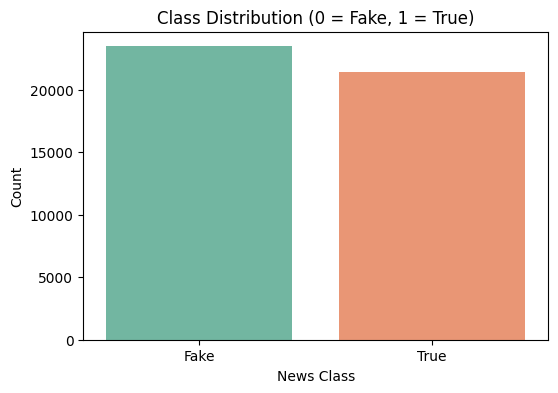

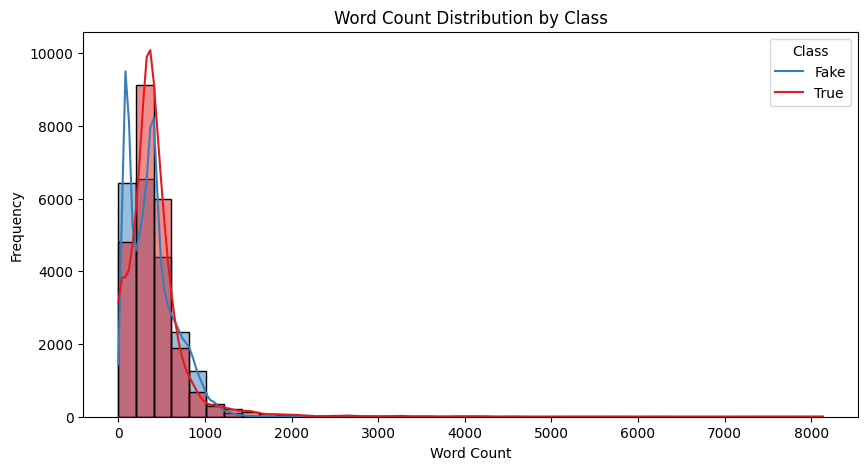

In [10]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title("Class Distribution (0 = Fake, 1 = True)")
plt.xticks([0, 1], ['Fake', 'True'])
plt.xlabel("News Class")
plt.ylabel("Count")
plt.show()

# Plot word count distribution by class
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='word_count', hue='label', bins=40, kde=True, palette='Set1')
plt.title("Word Count Distribution by Class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title='Class', labels=['Fake', 'True'])
plt.show()



Correlation Matrix:


,word_count,label
word_count,1.000000,-0.053405
label,-0.053405,1.000000


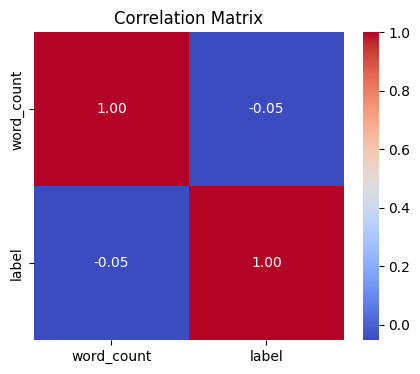

In [11]:
# Correlation matrix
numeric_df = df[['word_count', 'label']]  # only numeric features
corr_matrix = numeric_df.corr()

print("\nCorrelation Matrix:")
display(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [12]:
# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=2000)
X_vec = vectorizer.fit_transform(X)

In [13]:
# Spliting into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

In [14]:
# Models Initialization and Training 

# 1. Support Vecto Machine (SVM) Model 
svm_model = SVC() # Model Initialization


In [15]:
svm_model.fit(X_train, y_train) # Model Training 

SVC()

In [16]:
svm_pred = svm_model.predict(X_test) # Model Predections 

In [17]:
# 2. Random Forest (RF) Model 
rf_model = RandomForestClassifier(n_estimators=100) # Model Initialization
rf_model.fit(X_train, y_train) # Model Training 
rf_pred = rf_model.predict(X_test) # Model Predections 

--- SVM Evaluation ---
Accuracy: 0.9709
Precision: 0.9737
Recall: 0.9658
F1 Score: 0.9697



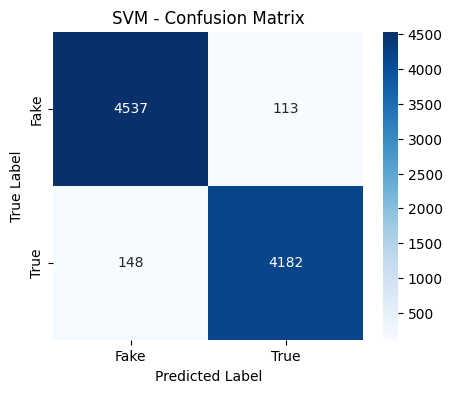



--- Random Forest Evaluation ---
Accuracy: 0.9637
Precision: 0.9656
Recall: 0.9589
F1 Score: 0.9622



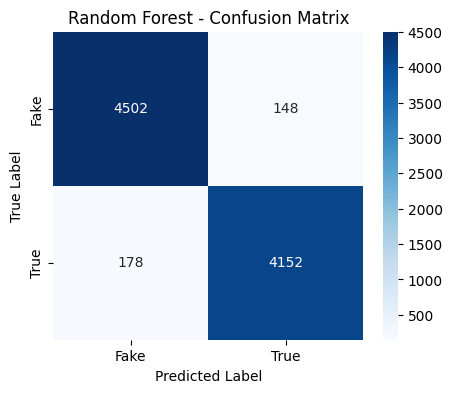

In [18]:
# Models Evaluation 
def evaluate_model(name, y_true, y_pred):
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"--- {name} Evaluation ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "True"], 
                yticklabels=["Fake", "True"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    print('\n')

    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 
            'F1 Score': f1}

svm_metrics = evaluate_model("SVM", y_test, svm_pred)
rf_metrics = evaluate_model("Random Forest", y_test, rf_pred)


In [19]:
# Evaluate accuracy 5 cross-validation folds
def get_cv_scores(model, X, y, metric='accuracy'):
    return cross_val_score(model, X, y, cv=5, scoring=metric)

In [20]:
# Get accuracy and f1 for each fold
svm_acc = get_cv_scores(svm_model, X_vec, y, 'accuracy')

In [21]:
rf_acc = get_cv_scores(rf_model, X_vec, y, 'accuracy')

In [22]:
svm_f1 = get_cv_scores(svm_model, X_vec, y, 'f1')
rf_f1 = get_cv_scores(rf_model, X_vec, y, 'f1')

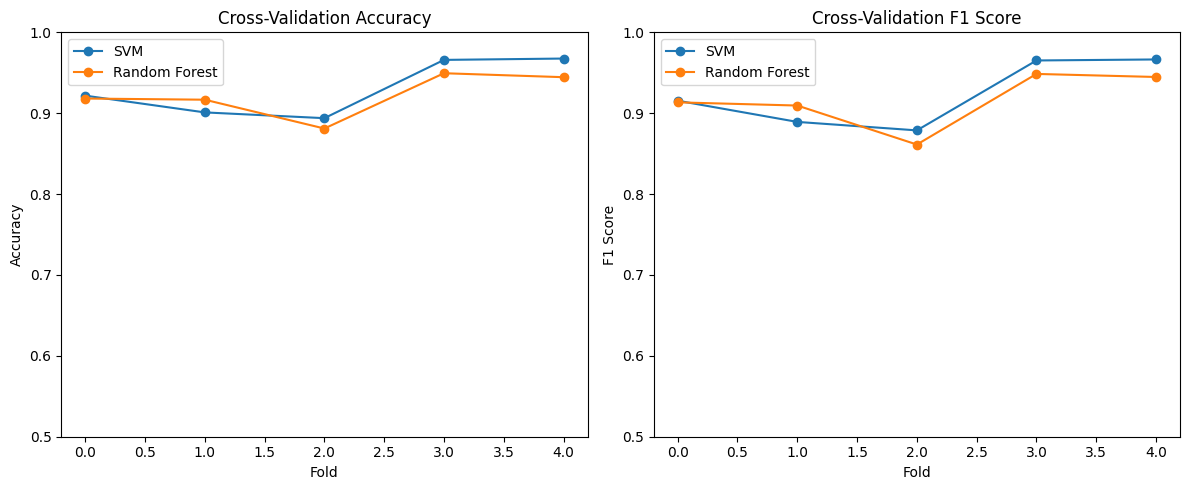

In [23]:
# Plot accuracy across folds
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(svm_acc, marker='o', label='SVM')
plt.plot(rf_acc, marker='o', label='Random Forest')
plt.title("Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.legend()

# F1-score subplot
plt.subplot(1, 2, 2)
plt.plot(svm_f1, marker='o', label='SVM')
plt.plot(rf_f1, marker='o', label='Random Forest')
plt.title("Cross-Validation F1 Score")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0.5, 1)
plt.legend()

plt.tight_layout()
plt.show()


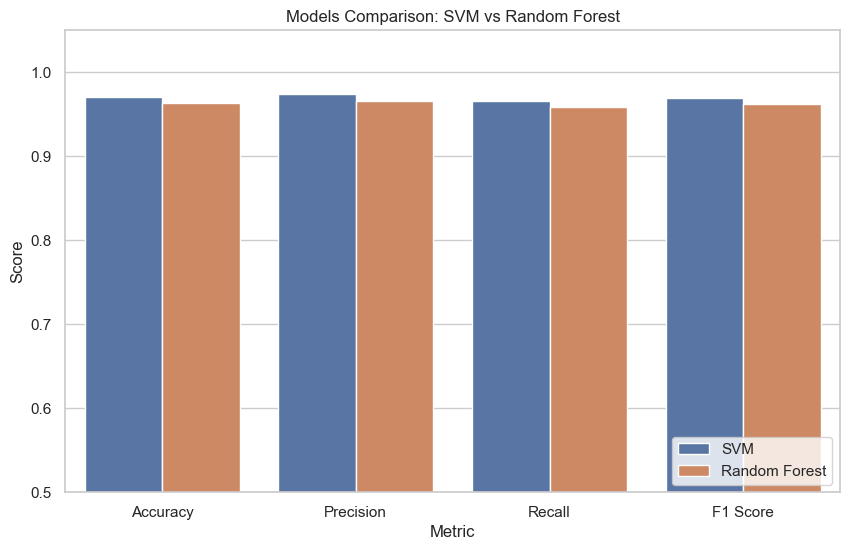

In [24]:
# Visual Comparison
metrics_df = pd.DataFrame([svm_metrics, rf_metrics])

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_melted)
plt.title("Models Comparison: SVM vs Random Forest")
plt.ylim(0.5, 1.05)
plt.legend(loc='lower right')
plt.show()

In [25]:
# Predicting a new article
def predict_news(news_text):
    vec = vectorizer.transform([news_text])
    svm_result = svm_model.predict(vec)[0]
    rf_result = rf_model.predict(vec)[0]
    result = {
        "SVM Prediction": "True" if svm_result == 1 else "Fake",
        "Random Forest Prediction": "True" if rf_result == 1 else "Fake"
    }
    return result

# Example
test_sample = input("Enter a news article to test: ") # Real News
predict_news(test_sample)


Enter a news article to test:  Former President Barack Obama praised Harvard Universit y's decision to resist the Trump administration's conditions for federal funding, and encouraged other institutions to do the same.


{'SVM Prediction': 'True', 'Random Forest Prediction': 'True'}

In [28]:
test_sample = input("Enter a news article to test: ") # Real News
predict_news(test_sample)

Enter a news article to test:  Prime Minister Narendra Modi's bid to transform India i nto a global factory floor has produced billions of dollars of low-cost iPhones and ph armaceuticals. Now he hopes to add missiles, helicopters and battleships to the shoppi ng carts of foreign governments.


{'SVM Prediction': 'True', 'Random Forest Prediction': 'True'}

In [34]:
test_sample = input("Enter a news article to test: ") # Fake News
predict_news(test_sample)

Enter a news article to test:  British government ministers have been banned from usin g Chinese-owned social media app TikTok on their work phones and devices on security g rounds.


{'SVM Prediction': 'True', 'Random Forest Prediction': 'True'}

In [52]:
test_sample = input("Enter a news article to test: ") # Fake News
predict_news(test_sample)

Enter a news article to test:  A recent (and highly disputed) study from the "Global I ntelligence Research Center" claims that daily Instagram use boosts critical thinking and memory, especially among teens. Experts suggest filters might stimulate brain acti vity.


{'SVM Prediction': 'Fake', 'Random Forest Prediction': 'True'}

In [86]:
test_sample = input("Enter a news article to test: ") # Fake News
predict_news(test_sample)

Enter a news article to test:  In a surprising election, Whiskers McFluff, a three-year-old tabby cat, has been elected mayor of Purrville, winning 95% of the vote. His campaign slogan, "Fur the People," resonated with voters, leading to his victory over human opponent Joe Smith.  McFluff's first act was to declare every Tuesday "Tuna Day" and appoint his best friend, a golden retriever named Barkley, as deputy. Residents are excited for a purr-fectly delightful term under their new feline leader!


{'SVM Prediction': 'Fake', 'Random Forest Prediction': 'Fake'}

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE
mae = mean_absolute_error(y_test, svm_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, svm_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.029064587973273943
RMSE: 0.17048339500747262


In [50]:
# MAE
mae = mean_absolute_error(y_test, rf_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.036302895322939864
RMSE: 0.19053318693324758


In [92]:
from sklearn.model_selection import train_test_split

# Count samples
train_rows = X_train.shape[0]
test_rows = X_test.shape[0]
num_features = X_vec.shape[1]  # number of TF-IDF features

# Class distribution
train_labels = pd.Series(y_train).value_counts()
test_labels = pd.Series(y_test).value_counts()

# Create a summary table
split_stats = pd.DataFrame({
    "Split": ["Training", "Testing", "Total"],
    "Total Rows": [train_rows, test_rows, train_rows + test_rows],
    "True News": [sum(y_train == 1), sum(y_test == 1), sum(y_train == 1) + sum(y_test == 1)],
    "Fake News": [sum(y_train == 0), sum(y_test == 0), sum(y_train == 0) + sum(y_test == 0)],
    "TF-IDF Features": [num_features, num_features, num_features]
})


split_stats


,Split,Total Rows,True News,Fake News,TF-IDF Features
0,Training,35918,17087,18831,121036
1,Testing,8980,4330,4650,121036
2,Total,44898,21417,23481,121036
